<a href="https://colab.research.google.com/github/CorpuzKB/PML-Advance-Topics-notebooks/blob/main/HMM_SGD_Fitting__TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting an HMM using Stochastic Gradient Descent

The parameters $\boldsymbol\theta=(A, B, \pi)$ of an HMM are fitted by maximizing the log-likelihood:
\begin{align*}
\log \Pr(\mathbf y_{1}\cdots, \mathbf y_N|\boldsymbol \theta) = \sum_{n=1}^N\log \Pr(\mathbf y_n|\mathbf y_{1}\cdots \mathbf y_{n-1}, \boldsymbol \theta)
\end{align*}

This is simply the normalizing constant used in the Forwards step of an HMM state inference (see [HMM Inference](https://colab.research.google.com/drive/12JfQRmJOgHXOE1j-gXjfSDHlODpp3RVE?usp=sharing)). Since for every filtered posterior from $1\cdots N$:
\begin{align*}
\boldsymbol\alpha_t&= \Pr(\mathbf z_t|\mathbf y_{1}\cdots \mathbf y_{t}, \boldsymbol\theta\\
&=\frac{\Pr(\mathbf z_t, \mathbf y_{1}\cdots \mathbf y_{t}|\boldsymbol\theta)}{\Pr(\mathbf y_n|\mathbf y_{1}\cdots \mathbf y_{n-1}, \boldsymbol \theta)}
\end{align*}

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats

tfd = tfp.distributions
sns.set(rc={"figure.dpi":80, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
set_matplotlib_formats('retina')

## HMM Inference TensorFlow Module

In [54]:
class HMM_Inference_TFM(tf.Module):
  def __init__(self, transition_distribution, emission_distribution, emission_params, initial_distribution, transformation_layer, **kwargs):
    super().__init__(**kwargs)
    self.transition_distribution = tf.Variable(transition_distribution, dtype=tf.float32, name='transition_matrix')
    self.emission_params = tf.Variable(emission_params, dtype=tf.float32, name='emission_params')
    self.initial_distribution = tf.Variable(initial_distribution, dtype=tf.float32, name='initial_distribution')
    self.emission_distribution = emission_distribution
    self.transformation_layer = transformation_layer

  def __call__(self, observations):
    return self.Forward(*self.transformation_layer(
        self.transition_distribution, 
        self.emission_distribution, 
        self.emission_params, 
        self.initial_distribution))

  def normalizing_constant(self, x):
    return tf.reduce_sum(x, -2, keepdims=True)

  @tf.function
  def Forward(self, transition_distribution, initial_distribution, local_evidence):
    filtered_Z = tf.TensorArray(local_evidence.dtype, size=0, dynamic_size=True)
    filtered_t = tf.broadcast_to(initial_distribution, local_evidence[:, 0].shape)
    filtered_Z_t = self.normalizing_constant(filtered_t)
    filtered_t = filtered_t / filtered_Z_t
    for i in tf.range(num_steps):
      filtered_t = local_evidence[:, i] * (tf.transpose(transition_distribution) @ filtered_t)
      filtered_Z_t = self.normalizing_constant(filtered_t)
      filtered_t = filtered_t / filtered_Z_t
      filtered_Z = filtered_Z.write(i, filtered_Z_t)
    return tf.transpose(filtered_Z.stack(), [1, 0, 2, 3])

In [55]:
class HMM_Categorical_Layer(tf.keras.layers.Layer):
    def __init__(self):
      super().__init__()

    def call(self, transition_distribution, emission_distribution, emission_params, initial_distribution):
      transition_distribution = tf.nn.softmax(transition_distribution)
      emission_model = emission_distribution(tf.nn.softmax(emission_params))
      local_evidence = tf.exp(emission_model.log_prob(observations))[..., tf.newaxis]
      initial_distribution = tf.nn.softmax(initial_distribution, axis=0)
      return transition_distribution, initial_distribution, local_evidence

## SGD Loss Function and Training Routine

In [5]:
@tf.function
def SGD_step(inference_module, inference_loss, observations):
  with tf.GradientTape() as tape:
    loss = inference_loss(inference_module, observations)
  grads = tape.gradient(loss, inference_module.trainable_variables)
  return grads, loss

def HMM_Negative_Log_Likelihood(inference_module, observations):
  return -tf.reduce_sum(tf.math.log(inference_module(observations)))

def HMM_SGD(inference_module, inference_loss, observations, optimizer, iterations=1):
  loss = []
  for i in tf.range(iterations):
    grads, HMM_NLL = SGD_step(inference_module, inference_loss, observations)
    optimizer.apply_gradients(zip(grads, inference_module.trainable_variables))
    loss.append(HMM_NLL)
    tf.print("Iteration: ", i + 1, '\tNLL = ', HMM_NLL)
  return loss

## HMM Observations Generator

In [6]:
@tf.function
def HMM_Generator(transition_matrix, emission_distribution, emission_params, states_probs_0, steps, batch_dims=1):
  state_t = tfd.Categorical(probs=tf.squeeze(states_probs_0)).sample([batch_dims, 1])
  transition_distribution = tfd.Categorical(probs=transition_matrix).sample([batch_dims, steps])
  observation_distribution = emission_distribution(emission_params).sample([batch_dims, steps])
  state = tf.TensorArray(state_t.dtype, size=0, dynamic_size=True)
  obs = tf.TensorArray(observation_distribution.dtype, size=0, dynamic_size=True, clear_after_read=False)
  for i in tf.range(steps):
    state_t = tf.gather_nd(transition_distribution[:, i], state_t, 1)[:, tf.newaxis]
    obs_t = tf.gather_nd(observation_distribution[:, i], state_t, 1)[:, tf.newaxis]
    state = state.write(i, state_t)
    obs = obs.write(i, obs_t)
  return tf.transpose(state.stack(), [1, 0, 2]), tf.transpose(obs.stack(), [1, 0, 2])

# Example 1. Casino HMM Parameter Learning Using SGD

### Set the ground-truth parameters $(A_g, B_g, \pi_g)$

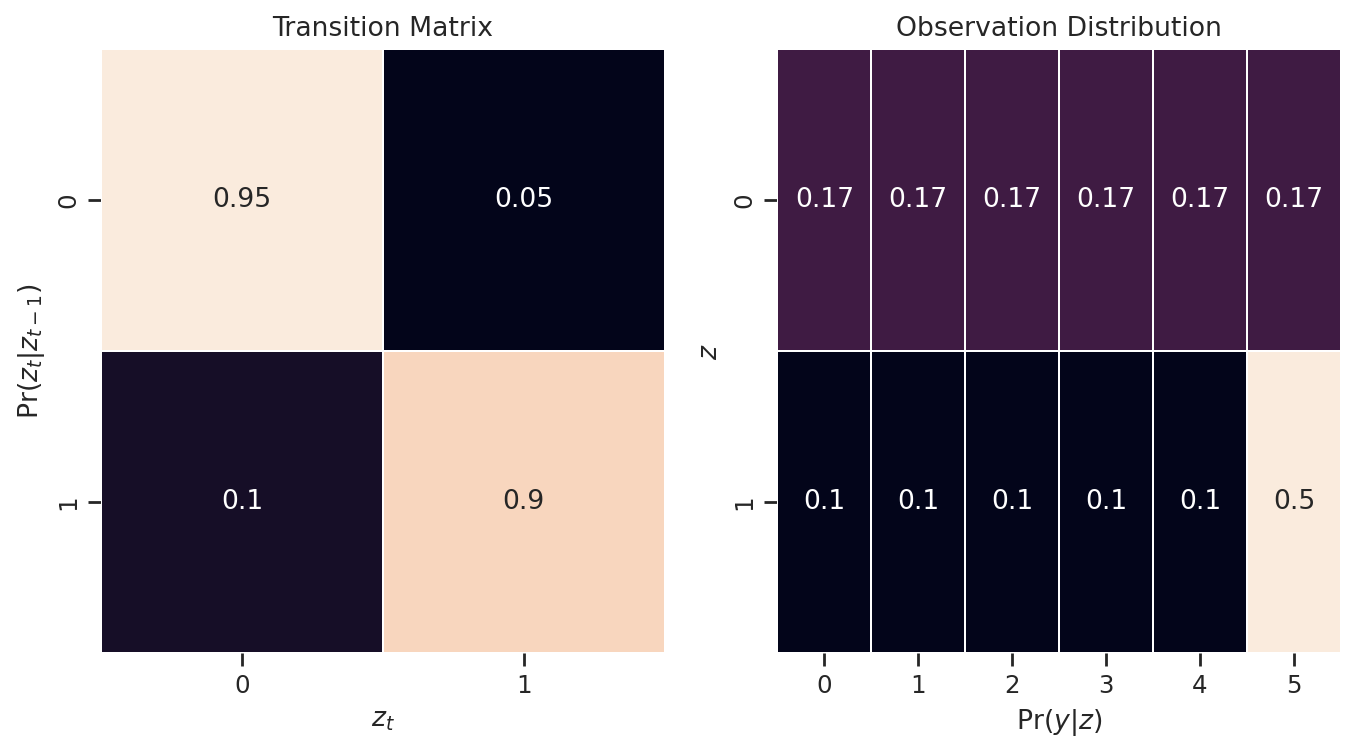

In [10]:
num_states = 2

initial_distribution = tf.constant([
    [0.5],
    [0.5]
])

transition_distribution = tf.constant([
    [0.95, 0.05], 
    [0.10, 0.90]
])

emission_params = tf.stack([
    tf.squeeze(tf.constant(tf.fill([1, 6], 1/6))),
    tf.constant([*[1/10 for _ in range(5)], 5/10])
    ])

emission_distribution = lambda arg: tfd.Categorical(probs=arg)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(transition_distribution, annot=True, linewidth=.5, ax=axes[0], cbar=False)
sns.heatmap(emission_params, annot=True, linewidth=.5, ax=axes[1], cbar=False)
axes[0].set(xlabel='$z_{t}$', ylabel='$\Pr(z_{t}|z_{t-1})$', title='Transition Matrix')
axes[1].set(xlabel='$\Pr(y|z)$', ylabel='$z$', title='Observation Distribution'); plt.show()

### Generate Sample Data

In [39]:
num_batches = 10
num_steps = 5000
true_states, observations = HMM_Generator(transition_distribution, emission_distribution, emission_params, initial_distribution, num_steps, num_batches)
print('Generated {} batches of {}-step Casino HMM samples'.format(num_batches, num_steps), '\n')

Generated 10 batches of 5000-step Casino HMM samples 



### Start the training routine

In [56]:
transition_distribution_init = tf.constant([
    [0.5, 0.5],
    [0.5, 0.5]])

emission_params_init = tf.constant([
    [0.2, 0.1, 0.2, 0.3, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.2, 0.3, 0.2]])

initial_distribution_init = tf.constant([
    [0.5],
    [0.5]])

inference_module = HMM_Inference_TFM(transition_distribution_init, emission_distribution, emission_params_init, initial_distribution_init, HMM_Categorical_Layer())
optimizer=tf.keras.optimizers.Adam(learning_rate=0.1)
num_iter = 250
HMM_loss = HMM_SGD(inference_module, HMM_Negative_Log_Likelihood, observations, optimizer, iterations=num_iter)

Iteration:  1 	NLL =  89743.6562
Iteration:  2 	NLL =  88698.5859
Iteration:  3 	NLL =  87995.1719
Iteration:  4 	NLL =  87652.1719
Iteration:  5 	NLL =  87625.7812
Iteration:  6 	NLL =  87784.6719
Iteration:  7 	NLL =  87958.9922
Iteration:  8 	NLL =  88039.6562
Iteration:  9 	NLL =  88013.8
Iteration:  10 	NLL =  87919.8906
Iteration:  11 	NLL =  87802.9844
Iteration:  12 	NLL =  87697.9531
Iteration:  13 	NLL =  87627.2188
Iteration:  14 	NLL =  87600.4375
Iteration:  15 	NLL =  87613.8281
Iteration:  16 	NLL =  87651.4375
Iteration:  17 	NLL =  87690.8438
Iteration:  18 	NLL =  87712.6875
Iteration:  19 	NLL =  87708.7812
Iteration:  20 	NLL =  87683.3281
Iteration:  21 	NLL =  87647.9688
Iteration:  22 	NLL =  87616.1406
Iteration:  23 	NLL =  87597.8281
Iteration:  24 	NLL =  87596.3438
Iteration:  25 	NLL =  87607.4062
Iteration:  26 	NLL =  87621.7188
Iteration:  27 	NLL =  87630.4375
Iteration:  28 	NLL =  87629.7344
Iteration:  29 	NLL =  87621.2344
Iteration:  30 	NLL =  876

### Results

True parameters
[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1        0.1        0.1        0.1        0.1        0.5       ]]

[[0.5]
 [0.5]]

[[0.95 0.05]
 [0.1  0.9 ]] 

Trained parameters
[[0.1  0.1  0.1  0.1  0.1  0.5 ]
 [0.16 0.16 0.17 0.17 0.17 0.17]] 

[[0.67]
 [0.33]] 

[[0.9  0.1 ]
 [0.05 0.95]] 



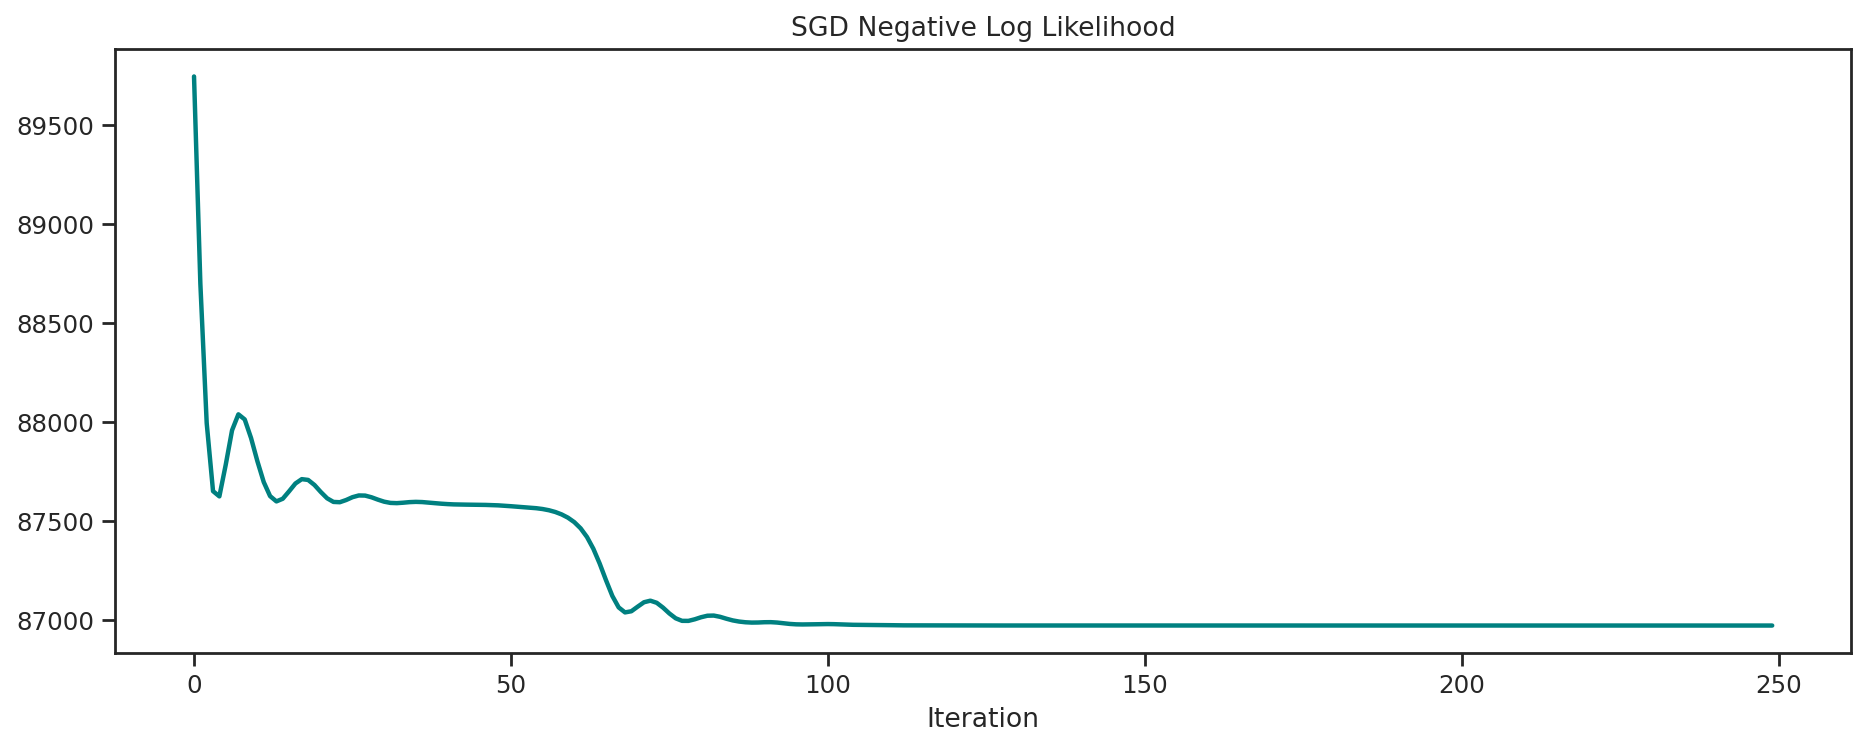

In [58]:
tf.print('True parameters\n{}\n\n{}\n\n{}'.format(emission_params, initial_distribution, transition_distribution), '\n\nTrained parameters')
SGD_trained = [tf.nn.softmax(inference_module.trainable_variables[0]).numpy(),
              tf.nn.softmax(inference_module.trainable_variables[1], axis=0).numpy(),
              tf.nn.softmax(inference_module.trainable_variables[2]).numpy()]

for params in SGD_trained:
  print(np.round(params, 2), '\n')

plt.figure(figsize=(14, 5))
plt.plot(HMM_loss, color="teal", linewidth=2)
plt.title("SGD Negative Log Likelihood"); plt.xlabel('Iteration'); plt.show()

# Example 2. Gaussian HMM Parameter Learning (under construction)

In [ ]:
num_batches = 5
num_steps = 5000
num_states = 3
initial_distribution = tf.fill([num_states, 1], 1/num_states)

transition_distribution = tf.constant([
    [0.90, 0.05, 0.025], 
    [0.05, 0.925, 0.025],
    [0.025, 0.025, 0.95]])

emission_params = tf.constant([
    [1.0, 3.0, 5.0],
    [2.6, 1.2, 0.71]])

emission_distribution = lambda arg: tfd.Normal(loc=arg[0], scale=arg[1])

true_states, observations = HMM_Generator(transition_distribution, emission_distribution, emission_params, initial_distribution, num_steps, num_batches)
print('Generated {} batches of {}-step Casino HMM samples'.format(num_batches, num_steps), '\n')

In [ ]:
@tf.function
def SGD_step(inference_module, inference_loss, observations):
  with tf.GradientTape() as tape:
    loss = inference_loss(inference_module, observations)
  grads = tape.gradient(loss, inference_module.trainable_variables)
  return grads, loss

def HMM_Negative_Log_Likelihood(inference_module, observations):
  for i, params in enumerate(inference_module.trainable_variables):
    if i == 0:
      tf.print(params)
      continue
    if i == 1:
      tf.print(tf.nn.softmax(params, 0), '\n')
      continue
    tf.print(tf.nn.softmax(params), '\n')
  return -tf.reduce_sum(tf.math.log(inference_module(observations)))

def HMM_SGD(inference_module, inference_loss, observations, optimizer, iterations=1):
  loss = []
  for i in tf.range(iterations):
    grads, HMM_NLL = SGD_step(inference_module, inference_loss, observations)
    optimizer.apply_gradients(zip(grads, inference_module.trainable_variables))
    loss.append(HMM_NLL)
    tf.print("Iteration: ", i + 1, '\tNLL = ', HMM_NLL)
  return loss

In [ ]:
class HMM_Gaussian_Layer(tf.keras.layers.Layer):
    def __init__(self):
      super().__init__()

    def call(self, transition_distribution, emission_distribution, emission_params, initial_distribution):
      transition_distribution = tf.nn.softmax(transition_distribution)
      emission_mean = emission_params[0]
      emission_cov = emission_params[1]*emission_params[1]
      emission_model = emission_distribution([emission_mean, emission_cov])
      local_evidence = tf.exp(emission_model.log_prob(observations))[..., tf.newaxis]
      initial_distribution = tf.nn.softmax(initial_distribution, axis=0)
      return transition_distribution, initial_distribution, local_evidence

In [ ]:
class HMM_Inference_TFM(tf.Module):
  def __init__(self, transition_distribution, emission_distribution, emission_params, initial_distribution, **kwargs):
    super().__init__(**kwargs)
    self.transition_distribution = tf.Variable(transition_distribution, dtype=tf.float32, name='transition_matrix')
    self.emission_params = tf.Variable(emission_params, dtype=tf.float32, name='emission_params')
    self.initial_distribution = tf.Variable(initial_distribution, dtype=tf.float32, name='initial_distribution')
    self.emission_distribution = emission_distribution

  def __call__(self, observations):
    emission_model = self.emission_distribution(self.emission_params)
    local_evidence = tf.exp(emission_model.log_prob(observations))[..., tf.newaxis]
    return self.Forward(self.transition_distribution, self.initial_distribution, local_evidence)

  def normalizing_constant(self, x):
    return tf.reduce_sum(x, -2, keepdims=True)

  def Forward(self, transition_distribution, initial_distribution, local_evidence):
    filtered_Z = tf.TensorArray(local_evidence.dtype, size=0, dynamic_size=True)
    filtered_t = tf.broadcast_to(tf.nn.softmax(initial_distribution, axis=0), local_evidence[:, 0].shape)
    filtered_Z_t = self.normalizing_constant(filtered_t)
    filtered_t = filtered_t / filtered_Z_t
    for i in tf.range(num_steps):
      filtered_t = local_evidence[:, i] * (tf.transpose(tf.nn.softmax(transition_distribution)) @ filtered_t)
      filtered_Z_t = self.normalizing_constant(filtered_t)
      filtered_t = filtered_t / filtered_Z_t
      filtered_Z = filtered_Z.write(i, filtered_Z_t)
    return tf.transpose(filtered_Z.stack(), [1, 0, 2, 3])

inference_module = HMM_Inference_TFM(transition_distribution_init, emission_distribution, emission_params_init, initial_distribution_init)
optimizer=tf.keras.optimizers.Adam(learning_rate=0.1)
num_iter = 500
HMM_loss = HMM_SGD(inference_module, HMM_Negative_Log_Likelihood, observations, optimizer, iterations=num_iter)

In [ ]:
transition_distribution_init = tf.constant([
    [0.4, 0.3, 0.3], 
    [0.4, 0.3, 0.3],
    [0.3, 0.4, 0.3]])

emission_params_init = tf.constant([
    [0.0, 1.0, 1.0],
    [1.0, 1.0, 1.0]])

initial_distribution_init = tf.constant([
    [0.3],
    [0.4],
    [0.3]])

inference_module = HMM_Inference_TFM(transition_distribution, emission_distribution, emission_params, initial_distribution_init)
optimizer=tf.keras.optimizers.Adam(learning_rate=0.1)
num_iter = 0
HMM_loss = HMM_SGD(inference_module, HMM_Negative_Log_Likelihood, observations, optimizer, iterations=num_iter)